In [1]:
from helpers import *

In [65]:
# plot a pretty picture in the current directory called "output.png"
simulator = mendelSim(precision = 1000, num_points=100000)
simulator.run_sim()

1.505979

In [13]:
# parallelize to speed up
def monteCarlo(precision, num_points, simStrat):
    # no plot simulator
    simulator = mendelSim(precision=precision, num_points=num_points, simStrat = simStrat, draw=False, niceColors=False)
    return simulator.run_sim()

In [14]:
# try to get a good estimate of the influence of num_points (s) and precision(i)
# alter amount of jobs to fit your system
# results for precision
# shuffle the input to enhance time estimate
inputPrecisionSize = 1000
inputPrecision = np.arange(inputPrecisionSize)
np.random.shuffle(inputPrecision)
resultsPrecision = Parallel(n_jobs=8)(delayed(monteCarlo)(simStrat = "random",precision = i, num_points = 30000)
                                      for i in notebook.tqdm(inputPrecision))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [33]:
# results for number of points
inputPointSize = 10000
inputPoints = np.arange(inputPointSize)
np.random.shuffle(inputPoints)
resultsPoints = Parallel(n_jobs=8)(delayed(monteCarlo)(simStrat = "random",precision = 100, num_points = i+1)
                                   for i in notebook.tqdm(inputPoints))

  0%|          | 0/10000 [00:00<?, ?it/s]

In [46]:
# investigate the convergence of the two parameters
# convert to np array to enhance speed

arrPrecision = np.array(resultsPrecision)
errorPrecision = abs(arrPrecision - arrPrecision[np.where(inputPrecision == inputPrecisionSize-1)][0])
precisionResult = np.array((inputPrecision, arrPrecision, errorPrecision))


arrPoints = np.array(resultsPoints)
errorPoints = abs(arrPoints - arrPoints[np.where(inputPoints == inputPointSize-1)[0]])
pointResult = np.array((inputPoints, arrPoints, errorPoints))


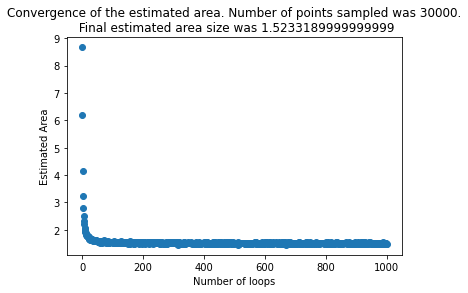

In [7]:
plt.scatter(precisionResult[0], precisionResult[1])
plt.ylabel("Estimated Area")
plt.xlabel("Number of loops")
plt.title(f"Convergence of the estimated area. Number of points sampled was 30000.\n Final estimated area size was {arrPrecision[-1]}")
plt.savefig("precisionArea.jpg")

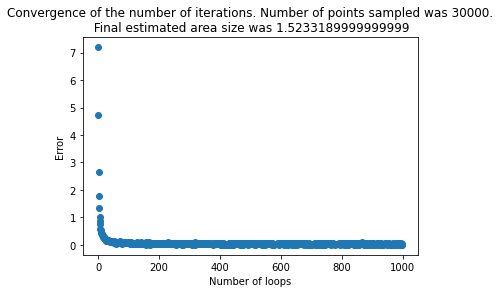

In [8]:
plt.scatter(precisionResult[0], precisionResult[2])
plt.ylabel("Error")
plt.xlabel("Number of loops")
plt.title(f"Convergence of the number of iterations. Number of points sampled was 30000.\n Final estimated area size was {arrPrecision[-1]}")
plt.savefig("precisionConvergence.jpg")

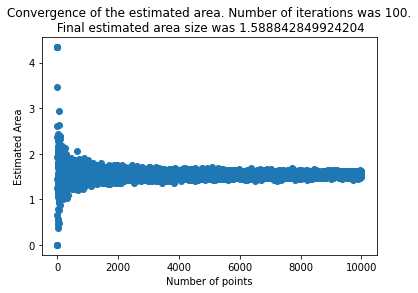

In [53]:
plt.scatter(pointResult[0], pointResult[1])
plt.ylabel("Estimated Area")
plt.xlabel("Number of points")
plt.title(f"Convergence of the estimated area. Number of iterations was 100.\n Final estimated area size was {arrPoints[-1]}")
plt.savefig("pointsArea.jpg")

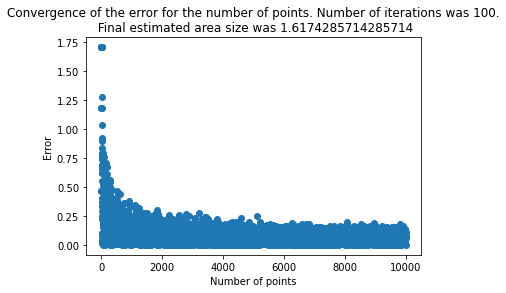

In [22]:
plt.scatter(pointResult[0], pointResult[2])
plt.ylabel("Error")
plt.xlabel("Number of points")
plt.title(f"Convergence of the error for the number of points. Number of iterations was 100.\n Final estimated area size was {arrPoints[-1]}")
plt.savefig("pointsConvergence.jpg")

In [11]:
simulator = mendelSim(simStrat = "latin", width = 1000, aspectRatio = 1, precision = 100)
simulator.run_sim()

1.3756399999999998

In [12]:
def monteCarloLatin(precision, width):
    simulator = mendelSim(simStrat = "latin", width = width, aspectRatio = 1, precision = precision, draw=False, niceColors=False)
    return simulator.run_sim()


In [13]:
#test convergence of latin hypercube strategy. This works a little differently, because our input points are dependent on the 
# width of the picture

inputPrecisionSize = 1000
inputPrecision = np.arange(inputPrecisionSize)
np.random.shuffle(inputPrecision)
resultsPrecision = Parallel(n_jobs=8)(delayed(monteCarloLatin)(precision = i, width = 10000)
                                      for i in notebook.tqdm(inputPrecision))

arrPrecision = np.array(resultsPrecision)
errorPrecision = abs(arrPrecision - arrPrecision[np.where(inputPrecision == inputPrecisionSize-1)][0])
precisionResult = np.array((inputPrecision, arrPrecision, errorPrecision))

  0%|          | 0/1000 [00:00<?, ?it/s]

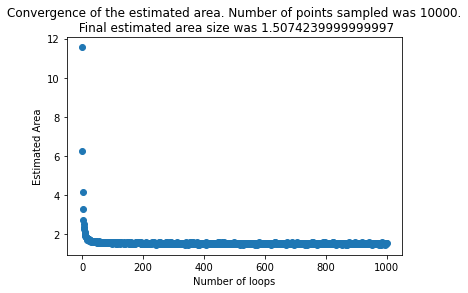

In [14]:
plt.scatter(precisionResult[0], precisionResult[1])
plt.ylabel("Estimated Area")
plt.xlabel("Number of loops")
plt.title(f"Convergence of the estimated area. Number of points sampled was 10000.\n Final estimated area size was {arrPrecision[-1]}")
plt.savefig("precisionAreaLatin.jpg")

In [23]:
inputPointSize = 10000
inputPoint = np.arange(inputPointSize)
np.random.shuffle(inputPoint)
resultsPoint = Parallel(n_jobs=8)(delayed(monteCarloLatin)(precision = 100, width = i+1)
                                      for i in notebook.tqdm(inputPoint))

arrPoint = np.array(resultsPoint)
errorPoint = abs(arrPoint - arrPoint[np.where(inputPoint == inputPointSize-1)][0])
pointResult = np.array((inputPoint, arrPoint, errorPoint))

  0%|          | 0/10000 [00:00<?, ?it/s]

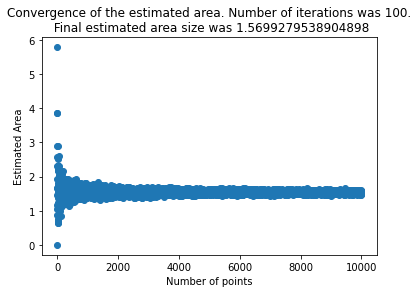

In [25]:
plt.scatter(pointResult[0], pointResult[1])
plt.ylabel("Estimated Area")
plt.xlabel("Number of points")
plt.title(f"Convergence of the estimated area. Number of iterations was 100.\n Final estimated area size was {arrPoint[-1]}")
plt.savefig("pointsAreaLatin.jpg")

In [43]:
simulator = mendelSim(simStrat = "orthogonal", width = 4**2, aspectRatio = 1, precision = 100)
simulator.run_sim()

1.4449999999999998

In [2]:
def monteCarloOrtho(precision, width):
    simulator = mendelSim(simStrat = "orthogonal", width = width, aspectRatio = 1, precision = precision, draw=False, niceColors=False)
    return simulator.run_sim()

In [8]:
#test convergence of orthogonal latin hypercube strategy. This works a little differently, 
# because our input points are dependent on the square of the width of the picture

inputPrecisionSize = 500
inputPrecision = np.arange(inputPrecisionSize)
np.random.shuffle(inputPrecision)
resultsPrecision = Parallel(n_jobs=8)(delayed(monteCarloOrtho)(precision = i, width = 35**2)
                                      for i in notebook.tqdm(inputPrecision))

arrPrecision = np.array(resultsPrecision)
errorPrecision = abs(arrPrecision - arrPrecision[np.where(inputPrecision == inputPrecisionSize-1)][0])
precisionResult = np.array((inputPrecision, arrPrecision, errorPrecision))

  0%|          | 0/500 [00:00<?, ?it/s]

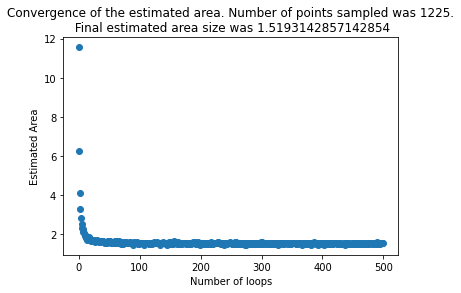

In [5]:
plt.scatter(precisionResult[0], precisionResult[1])
plt.ylabel("Estimated Area")
plt.xlabel("Number of loops")
plt.title(f"Convergence of the estimated area. Number of points sampled was {35**2}.\n Final estimated area size was {arrPrecision[-1]}")
plt.savefig("precisionAreaOrtho.jpg")

In [3]:
inputPointSize = 80
inputPoint = np.arange(inputPointSize)
np.random.shuffle(inputPoint)
resultsPoint = Parallel(n_jobs=6)(delayed(monteCarloOrtho)(precision = 500, width = (i+1)**2)
                                      for i in notebook.tqdm(inputPoint))

arrPoint = np.array(resultsPoint)
errorPoint = abs(arrPoint - arrPoint[np.where(inputPoint == inputPointSize-1)][0])
pointResult = np.array((inputPoint, arrPoint, errorPoint))

  0%|          | 0/80 [00:00<?, ?it/s]

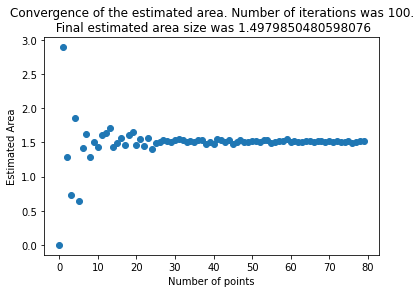

In [4]:
plt.scatter(pointResult[0], pointResult[1])
plt.ylabel("Estimated Area")
plt.xlabel("Number of points")
plt.title(f"Convergence of the estimated area. Number of iterations was 100.\n Final estimated area size was {arrPoint[-1]}")
plt.savefig("pointsAreaOrtho.jpg")

In [64]:
# perform statistics
import scipy.stats as st

inpSort = precisionResult
# sort the results
results = []
for entry in range(len(inpSort[0])):
    results.append((inpSort[0][entry], inpSort[1][entry]))
    
def getKey(item):
    return item[0]

resultsSorted = sorted(results, key=getKey)
resultsArray = np.zeros((2, len(inpSort[0])), dtype=float)
for i in range(len(inpSort[0])):
    resultsArray[0][i] = float(resultsSorted[i][0])
    resultsArray[1][i] = float(resultsSorted[i][1])
    
# compute the confidence interval
inp = resultsArray[1][990:1000]
st.t.interval(0.95, len(inp)-1, loc=np.mean(inp), scale=st.sem(inp))

(1.5006460640646697, 1.5269757359353302)

In [63]:
len(resultsArray[0])

1000